In [3]:
from tree import Node, Production, ConstituencyTree
from cd_dynamic_program import compute_num_matching_subtrees_dp

import autograd.numpy as np
from autograd import grad
from joblib import Parallel, delayed
from random import seed, shuffle, sample, randrange
from scipy.spatial.distance import squareform

from GPy.kern.src.kern import Kern
from GPy.core import Param
from GPy.models import GPClassification

import seaborn as sb
import matplotlib.pyplot as plt

In [4]:
# Seeds and parameters
seed(42)
np.random.seed(42)

SMALL_NUM_SENTENCES = 100
LARGE_NUM_SENTENCES = 400

In [5]:
# Kernel class

class Custom_GPY(Kern):

    def __init__(self, input_dim, lamb, e, active_dims=None):
        super(Custom_GPY, self).__init__(input_dim, active_dims, 'custom')

        self.lamb = Param('lamb', lamb)
        self.lamb.constrain_positive()

        self.emb_scale = Param('emb_scale', e)
        self.emb_scale.constrain_positive()

        self.link_parameters(self.lamb, self.emb_scale)

    def K(self, X, X2):
        """
        Compute the full kernel matrix

        :param X: np.array
        :param X2: np.array
        :return: np.array
        """
        n = X.shape[0]

        if X2 is None: # Symmetric case

            # Compute the upper triangular values
            vec = np.empty(shape=n * (n - 1) // 2)
            k = 0
            for i in range(n - 1):
                for j in range(i + 1, n):
                    vec[k] = compute_num_matching_subtrees_dp(t1=X[i, 0], t2=X[j, 0], lamb=self.lamb)
                    k += 1

            # Create a symmetric matrix from the upper triangular values (still has 0's on the main diagonal)
            CD = squareform(vec)

            # Compute the main diagonal
            CD_diag = np.empty(n)
            for i in range(n):
                CD_diag[i] = compute_num_matching_subtrees_dp(t1=X[i, 0], t2=X[i, 0], lamb=self.lamb)

            # Add the main diagonal to get the final Collins & Duffy matrix
            CD = CD + np.diag(CD_diag)

            # Calculate the embeddings matrix
            self.E_symm = self.emb_scale * np.array(np.matmul(X[:, 1:], X[:, 1:].T), dtype=np.float32)

            # Combine the C&D matrix with the embeddings matrix
            K = CD + self.E_symm

        else: # Non-symmetric case

            n2 = X2.shape[0]

            # Calculate the Collins & Duffy matrix
            CD = np.empty((n, n2))

            for i in range(n):
                for j in range(n2):
                    CD[i, j] = compute_num_matching_subtrees_dp(t1=X[i, 0], t2=X2[j, 0], lamb=self.lamb)

            # Calculate the embeddings matrix
            self.E_asymm = self.emb_scale * np.array(np.matmul(X[:, 1:], X2[:, 1:].T), dtype=np.float32)

            # Combine the C&D matrix with the embeddings matrix
            K = CD + self.E_asymm

        return K

    def Kdiag(self, X):
        """
        Compute the main diagonal of the kernel matrix

        :param X: np.array
        :return: np.array (1-dim)
        """
        n = X.shape[0]
        CD_diag = np.empty(n)
        E_diag = np.empty(n)
        for i in range(n):
            CD_diag[i] = compute_num_matching_subtrees_dp(t1=X[i, 0], t2=X[i, 0], lamb=self.lamb)
            E_diag[i] = self.emb_scale * np.dot(X[i, 1:], X[i, 1:])

        return CD_diag + E_diag

    def update_gradients_full(self, dL_dK, X, X2):
        """
        Compute the gradient of the loss function w.r.t the hyperparameters.

        :param dL_dK: np.array
        :param X: np.array
        :param X2: np.array
        :return: None
        """
        n = X.shape[0]

        # Set up the derivative of the C&D dynamic program w.r.t lambda
        part_deriv = grad(compute_num_matching_subtrees_dp, 2)

        if X2 is None:

            # Compute the upper triangular values of the dK/dlambda
            vec = np.empty(shape=n * (n - 1) // 2)
            k = 0
            for i in range(n - 1):
                for j in range(i + 1, n):
                    vec[k] = part_deriv(X[i, 0], X[j, 0], self.lamb*1)
                    k += 1

            # Create a symmetric matrix from the upper triangular values (still has 0's on the main diagonal)
            dlambda = squareform(vec)

            # Compute the main diagonal
            dlambda_diag = np.empty(n)
            for i in range(n):
                dlambda_diag[i] = part_deriv(X[i, 0], X[i, 0], self.lamb*1)

            # Add the main diagonal to get the final derivative
            dlambda = dlambda + np.diag(dlambda_diag)

            # Compute dL/demb_scale
            dE = self.E_symm / self.emb_scale
            self.emb_scale.gradient = np.sum(dE * dL_dK)

        else:

            n2 = X2.shape[0]

            # Evaluate the derivative at every element of the kernel matrix
            dlambda = np.empty((n, n2))
            for i in range(n):
                for j in range(n2):
                    dlambda[i, j] = part_deriv(X[i, 0], X2[j, 0], self.lamb*1)

            # Compute dL/demb_scale
            dE = self.E_asymm / self.emb_scale
            self.emb_scale.gradient = np.sum(dE * dL_dK)

        # Compute dL/dlambda
        self.lamb.gradient = np.sum(dlambda * dL_dK)
    
    def to_dict(self):
        
        input_dict = super()._save_to_input_dict()
        input_dict["class"] = "GPy.kern.CustomKernel"
        return input_dict

In [14]:
# Helper functions

def extract_sentences(data, sent_inds):
    """
    Extract the true parses, candidate parses and embeddings for the given sentences.

    :param data: list of np.arrays
    :param sent_inds: list of int
    :return: 3-tuple of lists
    """
    true_parses, parses, embeddings = data

    return [true_parses[ind] for ind in sent_inds], [parses[ind] for ind in sent_inds], [embeddings[ind] for ind in sent_inds]


def prepare_dataset(data, sent_inds):
    """
    Set up the data matrix and response vector from the parse trees and embeddings.

    :param data: list of np.arrays
    :param sent_inds: list of int
    :return: tuple of np.arrays
    """
    true_parses_ind, parses_ind, embeddings_ind = extract_sentences(data, sent_inds)

    # Compute the length of the dataset
    dataset_len = 0
    for cand_parse_arr in parses_ind:
        dataset_len += cand_parse_arr.shape[0] + 1  # +1 for the true parse

    # Initialize the response vector
    y = np.empty(shape=dataset_len)

    # Initialize the feature matrix
    embedding_length = embeddings_ind[0].shape[0] # ASSUMPTION: All embeddings have the same length
    X = np.empty(shape=(dataset_len, embedding_length + 1), dtype=object) # +1 for the trees

    ind = 0
    for sent_ind in range(len(true_parses_ind)):

        embedding = embeddings_ind[sent_ind]

        # True parse
        y[ind] = 1
        X[ind, 0] = true_parses_ind[sent_ind]
        X[ind, 1:] = embedding

        # Candidate parses
        num_cand_parses = parses_ind[sent_ind].shape[0]
        for cand_parse_ind in range(num_cand_parses):
            y[ind + cand_parse_ind + 1] = 0
            X[ind + cand_parse_ind + 1, 0] = parses_ind[sent_ind][cand_parse_ind]
            X[ind + cand_parse_ind + 1, 1:] = embedding # Embedding is the same for the candidates

        ind += num_cand_parses + 1

    return X, y


def fit_model(data, train_sent):
    """
    Fit a GPClassification model based on the train_sent

    :param data: list of np.arrays
    :param sent_inds: list of int
    :return: tuple of np.arrays
    """
    X_train, y_train = prepare_dataset(data=data, sent_inds=train_sent)
    
    kernel = Custom_GPY(input_dim=X_train.shape[1],lamb=0.5122493885645022, e=0.019017003926375585) # average values from optimized model on 50 observations
    return GPClassification(X=X_train, Y=y_train.reshape(-1, 1), kernel=kernel)
    
    # Additional idea: Save the model -> problem so far: Node Object is not JSON serializable, i.e. make the class json serializable and re-run everything
    # Also: the kernel here has an additional method "to_dict", which is essential for that
    # gp_model.save_model(f"gp_model_{len(train_sent)}", compress=False, save_data=False)

def convert_into_corr_mat(cov_mat):
    """
    Convert a covariance matrix into a correlation matrix
    
    :param sent_inds: np.array
    :return: np.array
    """
    n = cov_mat.shape[0]
    upper_triang = np.empty(shape=n * (n - 1) // 2)
    k = 0
    for i in range(n - 1):
        for j in range(i + 1, n):
            upper_triang[k] = cov_mat[i,j]/(np.sqrt(cov_mat[i,i])*np.sqrt(cov_mat[j,j]))
            k += 1

    # Create a symmetric matrix from the upper triangular values (still has 0's on the main diagonal)
    corr = squareform(upper_triang)
    corr = corr + np.diag(np.ones(n))
    
    return corr

In [7]:
# Load the data (assuming they were already generated - run save_model in data_generator.py first)
true_parses = np.load("true_parses.npy", allow_pickle=True)
cand_parses = np.load("cand_parses.npy", allow_pickle=True)
embeddings = np.load("embeddings.npy", allow_pickle=True)

In [8]:
# Adjust the number of sentences used
small_data = [true_parses[:SMALL_NUM_SENTENCES], cand_parses[:SMALL_NUM_SENTENCES], embeddings[:SMALL_NUM_SENTENCES]]
large_data = [true_parses[:LARGE_NUM_SENTENCES], cand_parses[:LARGE_NUM_SENTENCES], embeddings[:LARGE_NUM_SENTENCES]]

num_cands = small_data[1][0].shape[0] # Small and big dataset both have same constant number of candidate parse trees

In [9]:
# General idea for splitting: Make sure that the test set of the small data set is a subset of the test set of the large data set

# Sentences of small data set
small_sent = list(range(SMALL_NUM_SENTENCES))

# Take 1/2 of the data set randomly as the training set; the other half as test set
small_train_sent = sample(small_sent, k=int(len(small_sent)/2))
test_sent = [ind for ind in small_sent if ind not in small_train_sent]

# Exclude the sentences in small_test_sent from the large_sent before sampling the training set
large_sent = [sent for sent in list(range(LARGE_NUM_SENTENCES)) if sent not in test_sent]

# Sample again 1/2 of the total data points as training set
large_train_sent = sample(large_sent, k=int(len(large_sent)/2))

In [10]:
# Generate the test set for evaluating the covariance matrix
X_test, y_test = prepare_dataset(data=small_data, sent_inds=test_sent)

In [16]:
small_model = fit_model(data=small_data, train_sent=small_train_sent)

 c:\users\flori\anaconda3\envs\mt\lib\site-packages\numpy\core\fromnumeric.py:87: VisibleDeprecationWarning:Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [17]:
large_model = fit_model(data=large_data, train_sent=large_train_sent)

 c:\users\flori\anaconda3\envs\mt\lib\site-packages\autograd\tracer.py:14: UserWarning:Output seems independent of input.


In [18]:
post_mu_small, post_var_small = small_model._raw_predict(X_test, full_cov=True)
post_mu_large, post_var_large = large_model._raw_predict(X_test, full_cov=True)

In [25]:
# This does not help for visualization of the cov matrixes, but was an idea that we talked about
new_post_var_small = post_var_small.copy()
new_post_var_large = post_var_large.copy()
np.fill_diagonal(new_post_var_small, 0)
np.fill_diagonal(new_post_var_large, 0)

In [47]:
# Convert into correlation matrix
post_cor_small = convert_into_corr_mat(post_var_small)
post_cor_large = convert_into_corr_mat(post_var_large)

array([[1.        , 0.31762782, 0.44553425, ..., 0.02297846, 0.02112083,
        0.02091894],
       [0.31762782, 1.        , 0.53220251, ..., 0.05365931, 0.04434638,
        0.05205882],
       [0.44553425, 0.53220251, 1.        , ..., 0.04138348, 0.03196118,
        0.03924382],
       ...,
       [0.02297846, 0.05365931, 0.04138348, ..., 1.        , 0.46818188,
        0.56005291],
       [0.02112083, 0.04434638, 0.03196118, ..., 0.46818188, 1.        ,
        0.69807877],
       [0.02091894, 0.05205882, 0.03924382, ..., 0.56005291, 0.69807877,
        1.        ]])

<AxesSubplot:>

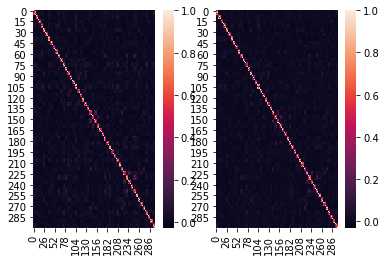

In [48]:
# Noch etwas breiter ziehen, dass es schöner aussieht

# All test samples -> Conclusion: Barely any correlations between the trees overall

fig, ax = plt.subplots(1,2)
sb.heatmap(post_cor_small, ax=ax[0])
sb.heatmap(post_cor_large, ax=ax[1])

<AxesSubplot:>

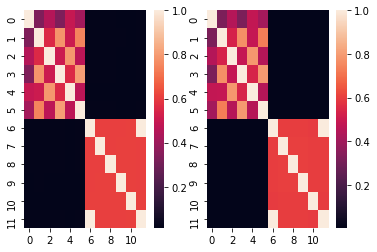

In [49]:
# Small amount of samples -> Conclusion: Correlations only within one reranking set

fig, ax = plt.subplots(1,2)
sb.heatmap(post_cor_small[:12,:12], ax=ax[0])
sb.heatmap(post_cor_large[:12,:12], ax=ax[1])

<AxesSubplot:>

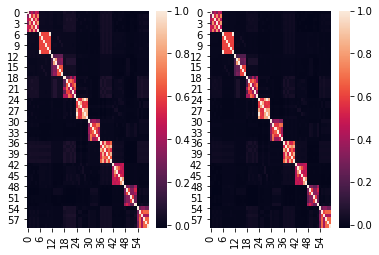

In [50]:
# Medium number of samples -> Conclusion: ?

fig, ax = plt.subplots(1,2)
sb.heatmap(post_cor_small[:60,:60], ax=ax[0])
sb.heatmap(post_cor_large[:60,:60], ax=ax[1])

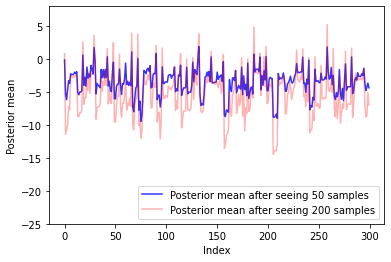

In [22]:
# Why is the performance still better though? - Answer lies in the mean function

plt.plot(post_mu_small, 'b-', alpha=0.8)
plt.plot(post_mu_large, 'r-', alpha=0.3)
plt.ylim([-25, 8])
plt.ylabel("Posterior mean")
plt.xlabel("Index")
plt.legend(["Posterior mean after seeing 50 samples", "Posterior mean after seeing 200 samples"], loc="lower right")